In [1]:
%matplotlib inline


# Thresholding


Thresholding is used to create a binary image from a grayscale image [1]_.
It is the simplest way to segment objects from a background.

Thresholding algorithms implemented in scikit-image can be separated in two
categories:

- Histogram-based. The histogram of the pixels' intensity is used and
  certain assumptions are made on the properties of this histogram (e.g. bimodal).
- Local. To process a pixel, only the neighboring pixels are used.
  These algorithms often require more computation time.


If you are not familiar with the details of the different algorithms and the
underlying assumptions, it is often difficult to know which algorithm will give
the best results. Therefore, Scikit-image includes a function to evaluate
thresholding algorithms provided by the library. At a glance, you can select
the best algorithm for you data without a deep understanding of their
mechanisms.

.. [1] https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29

.. seealso::
   Presentation on
   `sphx_glr_auto_examples_applications_plot_rank_filters.py`.


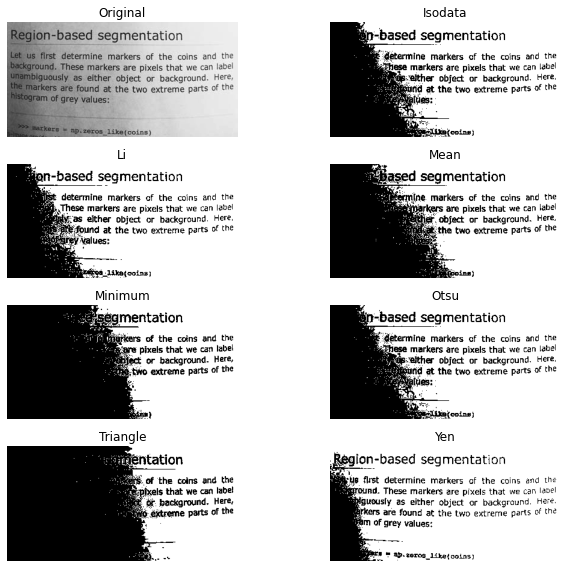

In [1]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import try_all_threshold

img = data.page()

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

How to apply a threshold?
=========================

Now, we illustrate how to apply one of these thresholding algorithms.
This example uses the mean value of pixel intensities. It is a simple
and naive threshold value, which is sometimes used as a guess value.




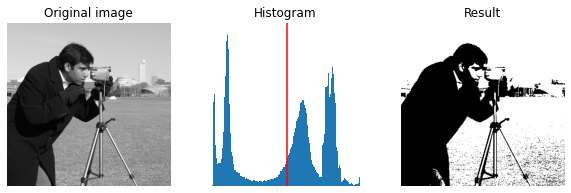

In [9]:
from skimage.filters import threshold_mean


image = data.camera()
thresh = threshold_mean(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

Bimodal histogram
=================

For pictures with a bimodal histogram, more specific algorithms can be used.
For instance, the minimum algorithm takes a histogram of the image and smooths it
repeatedly until there are only two peaks in the histogram.



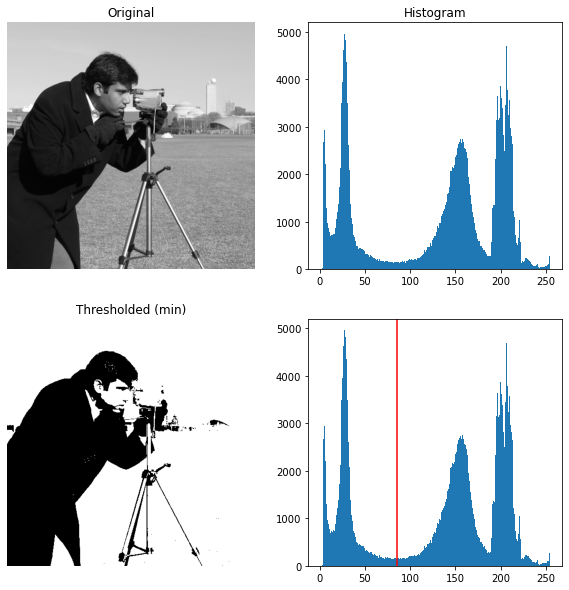

In [4]:
from skimage.filters import threshold_minimum


image = data.camera()

thresh_min = threshold_minimum(image)
binary_min = image > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

Otsu's method [2]_ calculates an "optimal" threshold (marked by a red line in the
histogram below) by maximizing the variance between two classes of pixels,
which are separated by the threshold. Equivalently, this threshold minimizes
the intra-class variance.

.. [2] https://en.wikipedia.org/wiki/Otsu's_method




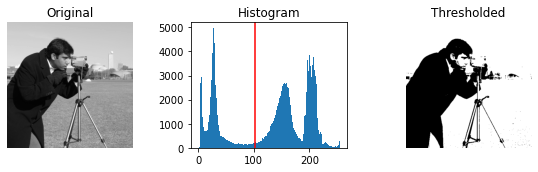

In [8]:
from skimage.filters import threshold_otsu


image = data.camera()
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.tight_layout()
plt.show()

Local thresholding
==================

If the image background is relatively uniform, then you can use a global
threshold value as presented above. However, if there is large variation in the
background intensity, adaptive thresholding (a.k.a. local or dynamic
thresholding) may produce better results. Note that local is much slower than
global thresholding.

Here, we binarize an image using the `threshold_local` function, which
calculates thresholds in regions with a characteristic size `block_size` surrounding
each pixel (i.e. local neighborhoods). **Each threshold value is the weighted mean
of the local neighborhood minus an offset value.**




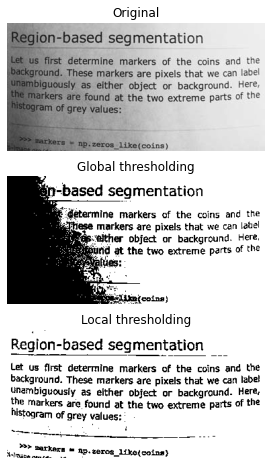

In [13]:
from skimage.filters import threshold_otsu, threshold_local


image = data.page()

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 35
local_thresh = threshold_local(image, block_size, offset=10)
binary_local = image > local_thresh

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()

Now, we show how Otsu's threshold [2]_ method can be applied locally. For
each pixel, an "optimal" threshold is determined by maximizing the variance
between two classes of pixels of the local neighborhood defined by a
structuring element.

The example compares the local threshold with the global threshold.




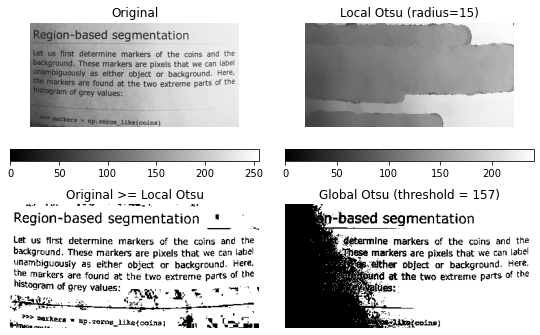

In [7]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte


img = img_as_ubyte(data.page())

radius = 15
selem = disk(radius)

local_otsu = rank.otsu(img, selem)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu

fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
ax = axes.ravel()
plt.tight_layout()

fig.colorbar(ax[0].imshow(img, cmap=plt.cm.gray),
             ax=ax[0], orientation='horizontal')
ax[0].set_title('Original')
ax[0].axis('off')

fig.colorbar(ax[1].imshow(local_otsu, cmap=plt.cm.gray),
             ax=ax[1], orientation='horizontal')
ax[1].set_title('Local Otsu (radius=%d)' % radius)
ax[1].axis('off')

ax[2].imshow(img >= local_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= Local Otsu' % threshold_global_otsu)
ax[2].axis('off')

ax[3].imshow(global_otsu, cmap=plt.cm.gray)
ax[3].set_title('Global Otsu (threshold = %d)' % threshold_global_otsu)
ax[3].axis('off')

plt.show()